<a href="https://colab.research.google.com/github/amrit123k/ResNet-AgePredictor/blob/main/ResNet_AgePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro
This project aims to predict a person's age from facial images using deep learning techniques. A pre-trained ResNet50 convolutional neural network was fine-tuned to perform regression on a dataset of labeled face images, where the target variable is the actual age. The pipeline includes exploratory data analysis (EDA) to understand the dataset's structure and distribution, followed by preprocessing and model training using mean squared error (MSE) as the loss metric. The ultimate goal is to evaluate whether computer vision can reliably estimate age and explore how this capability might assist businesses or services in automating tasks like age verification or customer profiling.

In [2]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


## EDA

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/NN-Datasets/faces/datasets/faces/final_files'
import os

if os.path.exists(path):
    print("Path exists!")
else:
    print("Path does not exist")


Mounted at /content/drive
Path exists!


In [4]:
df = pd.read_csv('/content/drive/MyDrive/NN-Datasets/faces/datasets/faces/labels.csv')
df

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
print(df.shape)
print(f'Number of images: {df.shape[0]}')

(7591, 2)
Number of images: 7591


Checking null and duplicate values, there are none.

In [6]:
df.isna().sum()

,0
file_name,0
real_age,0


In [7]:
df.duplicated().sum()

np.int64(0)

Looking at the distribution of ages:

In [8]:
df['real_age'].describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [9]:
df_age = df.groupby('real_age').count().rename(columns = {'file_name' : 'total_count'}).sort_values(by = 'total_count', ascending = False).reset_index()
df_age

,real_age,total_count
0,30,317
1,25,315
2,27,229
3,26,226
4,28,217
...,...,...
92,95,2
93,93,1
94,91,1
95,97,1


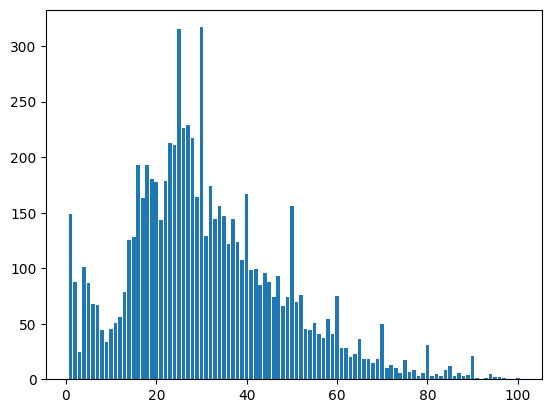

In [10]:
plt.bar(df_age['real_age'], df_age['total_count'])
plt.show()

Here are 15 images so we can have a general idea of how the images looks

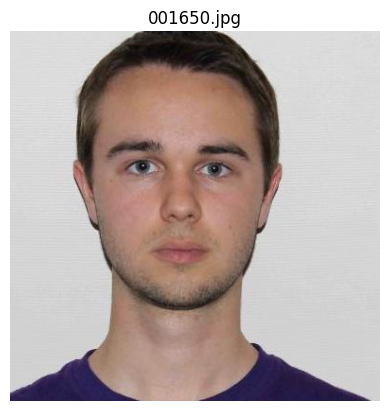

Dimensions: 391x391


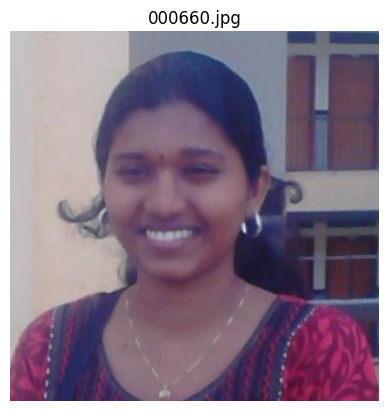

Dimensions: 418x419


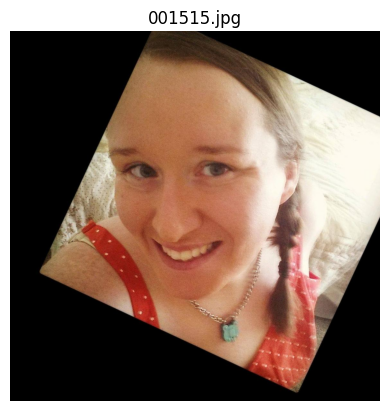

Dimensions: 1150x1150


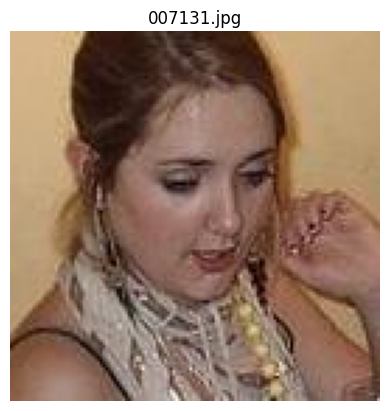

Dimensions: 132x132


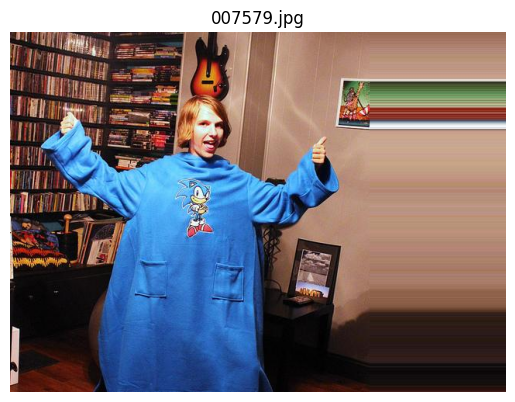

Dimensions: 640x465


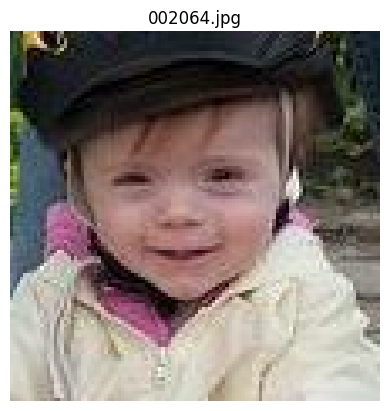

Dimensions: 110x110


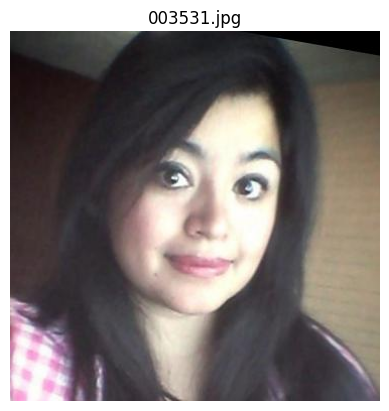

Dimensions: 367x367


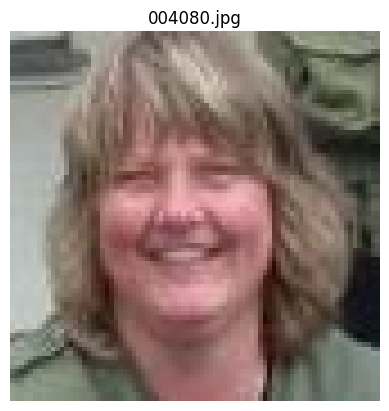

Dimensions: 82x82


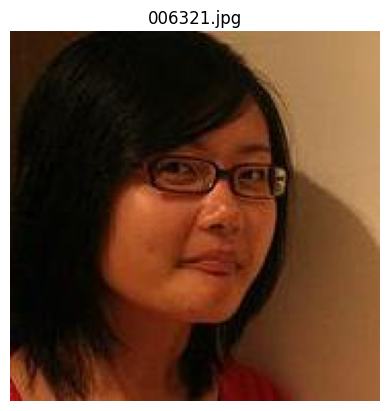

Dimensions: 180x180


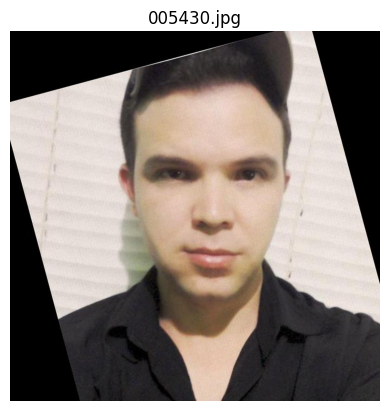

Dimensions: 688x688


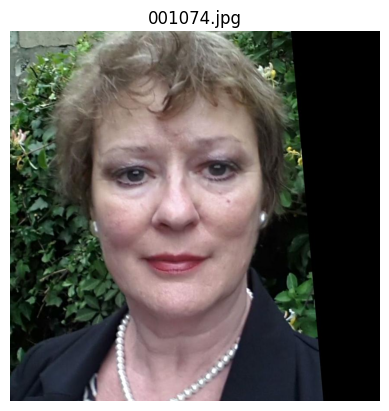

Dimensions: 853x853


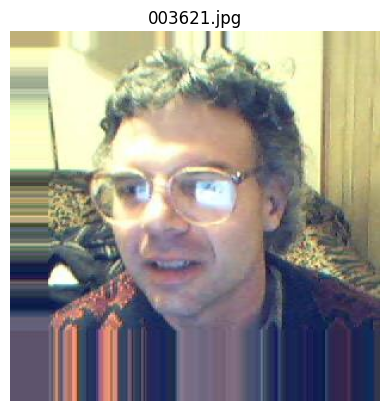

Dimensions: 310x310


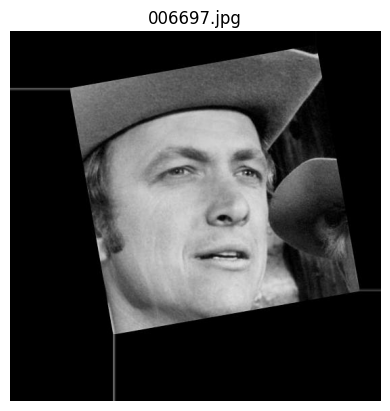

Dimensions: 548x547


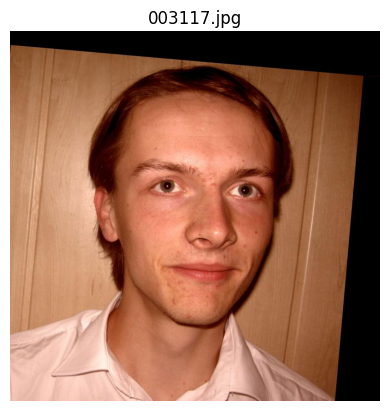

Dimensions: 974x974


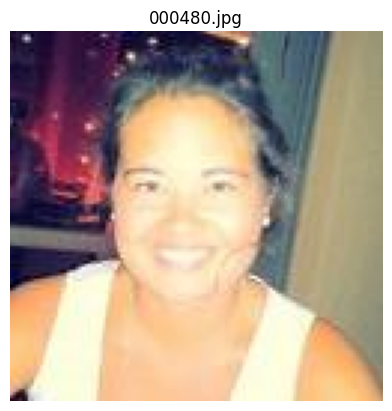

Dimensions: 125x124


In [12]:
import os
from PIL import Image

image_files = [f for f in os.listdir(path)]

for img_file in image_files[:15]:
    img_path = os.path.join(path, img_file)
    img = Image.open(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file)
    plt.show()
    width, height = img.size
    print(f"Dimensions: {width}x{height}")

Here is a scatterplot so we can generalize what the dimensions of the images are like:

Text(0, 0.5, 'Height')

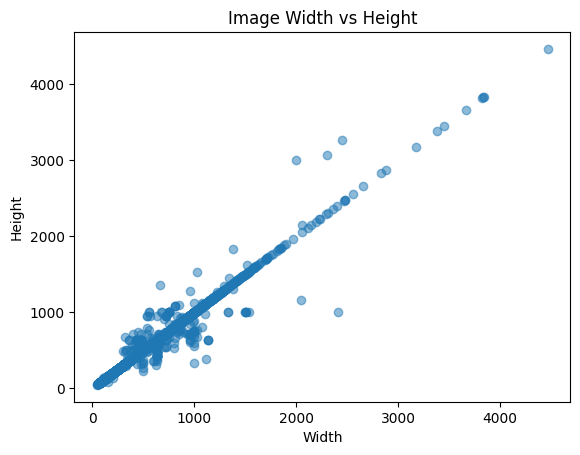

In [14]:
widths = []
heights = []
for img_file in image_files:
    img_path = os.path.join(path, img_file)
    img = Image.open(img_path)
    width, height = img.size
    widths.append(width)
    heights.append(height)

plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Width vs Height')
plt.xlabel('Width')
plt.ylabel('Height')

### Findings
Based on the findings, most of the ages gather between 20-40 so there might be some bias in regards to that towards the majority range and poor performance in worse age groups. Also the images in the dataset are not uniform in dimensions which indicates images were taken from different sources and this could affect model training stability.

## Model Training

In [16]:
datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255)

In [17]:
def load_train(path):


    """
    It loads the train part of dataset from path
    """
    train_gen_flow = datagen.flow_from_dataframe(dataframe=df, directory = path, target_size = (224,224), x_col='file_name',
    y_col='real_age', batch_size = 16, class_mode = 'raw', subset = 'training', seed = 12345)


    return train_gen_flow

In [18]:
def load_test(path):

    """
    It loads the validation/test part of dataset from path
    """
    test_gen_flow = datagen.flow_from_dataframe(dataframe=df, directory = path, target_size = (224,224), x_col='file_name',
    y_col='real_age', batch_size = 16, class_mode = 'raw', subset = 'validation', seed = 12345)

    return test_gen_flow

In [19]:
def create_model(input_shape):

    """
    It defines the model
    """

    backbone = ResNet50(input_shape=input_shape, classes=1, include_top=False, weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu'))


    return model

In [20]:
def train_model(model, train_data, test_data, batch_size=32, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    early_stop = EarlyStopping(
    monitor='val_loss',      # What to monitor (e.g., 'val_loss', 'val_accuracy')
    patience=6,              # How many epochs to wait before stopping if no improvement
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=train_data.samples//16,
          validation_steps=test_data.samples//16,
          callbacks=[early_stop],
          verbose=2)

    return model

In [21]:
train_gen_flow = load_train(path)
test_gen_flow = load_test(path)
model = create_model((224,224,3))
model

Found 5694 validated image filenames.
Found 1897 validated image filenames.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


<Sequential name=sequential, built=True>

In [22]:
fit = train_model(model, train_gen_flow, test_gen_flow, batch_size=32, epochs=30, steps_per_epoch=None, validation_steps=None)
fit

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
355/355 - 173s - 487ms/step - loss: 254.0944 - mse: 254.0944 - val_loss: 288.8575 - val_mse: 288.8575
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


355/355 - 13s - 36ms/step - loss: 345.8315 - mse: 345.8315 - val_loss: 281.0152 - val_mse: 281.0152
Epoch 3/30
355/355 - 72s - 202ms/step - loss: 191.2007 - mse: 191.2007 - val_loss: 2739.3750 - val_mse: 2739.3750
Epoch 4/30
355/355 - 13s - 37ms/step - loss: 139.9427 - mse: 139.9427 - val_loss: 2935.3975 - val_mse: 2935.3975
Epoch 5/30
355/355 - 129s - 363ms/step - loss: 168.7007 - mse: 168.7007 - val_loss: 526.7342 - val_mse: 526.7342
Epoch 6/30
355/355 - 12s - 35ms/step - loss: 172.8383 - mse: 172.8383 - val_loss: 613.8876 - val_mse: 613.8876
Epoch 7/30
355/355 - 130s - 365ms/step - loss: 146.8692 - mse: 146.8692 - val_loss: 163.6707 - val_mse: 163.6707
Epoch 8/30
355/355 - 13s - 35ms/step - loss: 138.3586 - mse: 138.3586 - val_loss: 166.5922 - val_mse: 166.5922
Epoch 9/30
355/355 - 129s - 364ms/step - loss: 120.2442 - mse: 120.2442 - val_loss: 148.8725 - val_mse: 148.8725
Epoch 10/30
355/355 - 21s - 59ms/step - loss: 172.0546 - mse: 172.0546 - val_loss: 138.9164 - val_mse: 138.9164


<Sequential name=sequential, built=True>

## Conclusions
The results from the ResNet50 model training show that the model was able to significantly reduce the mean squared error over 30 epochs, suggesting it effectively learned visual features to predict age from images. Although the validation loss fluctuated during training, it eventually stabilized, indicating a reliable generalization capability. This demonstrates that computer vision can indeed help the customer by automating age estimation, which could be useful in digital verification, content personalization, or demographic analysis. Beyond age prediction, the same model could be adapted for tasks like emotion detection, face-based access control, and many other tasks, the possibilities are endless. Overall, the results affirm the practicality of applying deep learning to solve real-world vision problems.